<a href="https://colab.research.google.com/github/kumarDeepak-su/Milestone_Project_AIML/blob/main/DEEPAK_CAPSTONE_AIML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

cwd_old = os.getcwd()
print('\nWorking Directory: ', cwd_old)

os.chdir('/content/drive/MyDrive/AIML_CAPSTONE')
print('Working directory has been changed')

cwd_new = os.getcwd()
print('\nCurrent Working Directory: ', cwd_new)


Working Directory:  /content
Working directory has been changed

Current Working Directory:  /content/drive/MyDrive/AIML_CAPSTONE


In [ ]:
import os
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import pydicom as dcm
import math
from tensorflow.keras.layers import Layer, Convolution2D, Flatten, Dense
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input 
import tensorflow.keras.utils as pltUtil
from tensorflow.keras.utils import Sequence




In [ ]:
labels = pd.read_csv("stage_2_train_labels.csv")
labels.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

In [ ]:
labels.shape

(30227, 6)

In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [ ]:
## we can see that all the null column values are with Target 0 indicating that those patients do not have penumonia
labels[labels.isnull().any(axis=1)].Target.value_counts()

0    20672
Name: Target, dtype: int64

In [ ]:
## we can see that all the non null column values are with Target 1 indicating that those patients have pneumonia
labels[~labels.isnull().any(axis=1)].Target.value_counts()

1    9555
Name: Target, dtype: int64

In [ ]:
## Distubution of Targets , there are 20672 records with no pneumonia and 9555 with pneumonia
labels.Target.value_counts()

0    20672
1     9555
Name: Target, dtype: int64

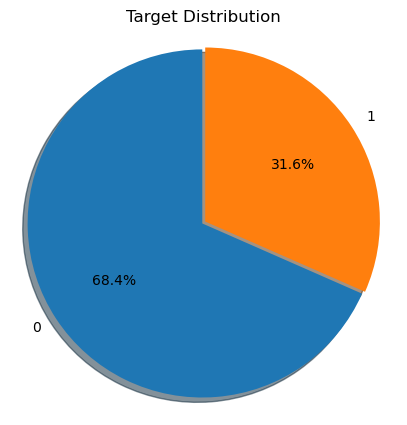

In [ ]:
## Disturbution of Target, there are 31% of patients with pneumonia and the remaining are no pneumonia
## There is a class imbalance issue
label_count=labels['Target'].value_counts()
explode = (0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Target Distribution')
plt.show()

In [ ]:
print("Are there Unique Patients In Data Set ?? " ,labels['patientId'].is_unique)

Are there Unique Patients In Data Set ??  False


In [ ]:
#labels.loc[labels.index.repeat(labels.patientId)]
duplicateRowsDF = labels[labels.duplicated(['patientId'])]
duplicateRowsDF.shape


(3543, 6)

In [ ]:
duplicateRowsDF.head(2)

patientId      x      y  width  height  Target
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
9  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1

In [ ]:
## Examining one of the patient id which is duplicate , we can see that the x,y, widht and height is not the same
## This indicates that the same patient has two bounding boxes in the same dicom image
labels[labels.patientId=='00436515-870c-4b36-a041-de91049b9ab4']

patientId      x      y  width  height  Target
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1

In [ ]:
labels[labels.patientId=='00704310-78a8-4b38-8475-49f4573b2dbb']

patientId      x      y  width  height  Target
8  00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1
9  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1

**Reading the class Info Data Set**

In [ ]:
## Reading the classes label , 
class_labels = pd.read_csv('"stage_2_train_labels.csv"')
class_labels.head()

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

In [ ]:
class_labels.shape

(30227, 2)

In [ ]:
class_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [ ]:
class_labels['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

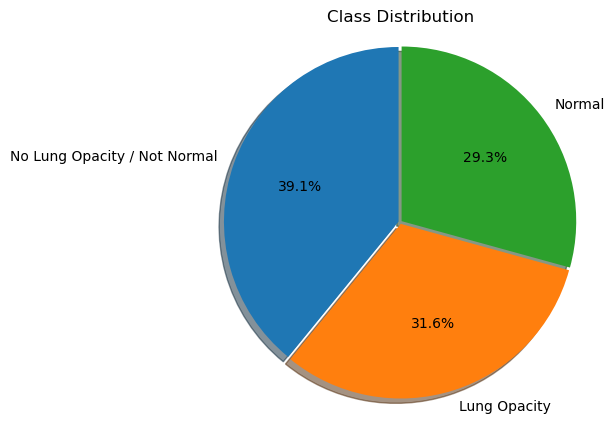

In [ ]:
label_count=class_labels['class'].value_counts()
explode = (0.01,0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Class Distribution')
plt.show()

In [ ]:
#labels.loc[labels.index.repeat(labels.patientId)]
duplicateClassRowsDF = class_labels[class_labels.duplicated(['patientId'])]
duplicateClassRowsDF.shape

(3543, 2)

In [ ]:
duplicateClassRowsDF.head(2)

patientId         class
5  00436515-870c-4b36-a041-de91049b9ab4  Lung Opacity
9  00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity

In [ ]:
## The same patient id has the same class even though they are duplicate
class_labels[class_labels.patientId=='00704310-78a8-4b38-8475-49f4573b2dbb']

patientId         class
8  00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity
9  00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity

Merging the class and labels data set into training dataset

In [ ]:
# Conctinating the two dataset - 'labels' and 'class_labels':
training_data = pd.concat([labels, class_labels['class']], axis = 1)

training_data.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity

Text(0.5, 1.0, 'Class and Target  Distrubution')

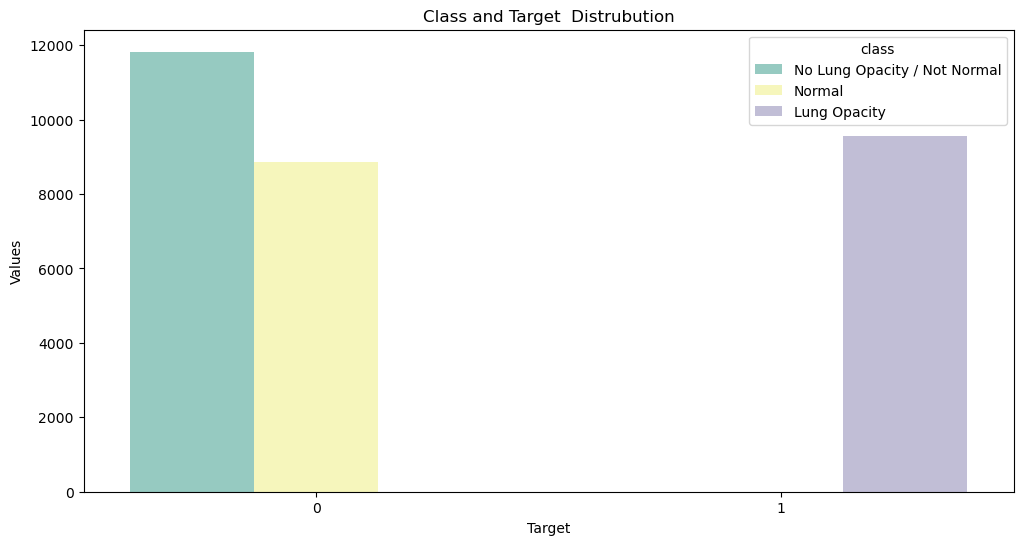

In [ ]:
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('Target')['class'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'class', data = data_target_class, palette = 'Set3')
plt.title('Class and Target  Distrubution')

## it shows that class distrubution grouped by Target 
## Target 0 has only Normal or No Lung Opacity class
## Target 1 has only Lung Opacity class

In [ ]:
import matplotlib.patches as patches

def inspectImages(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']
        dcm_file = 'stage_2_train_images'+'{}.dcm'.format(patientImage)
        data_row_img_data = dcm.read_file(dcm_file)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(dcm_file)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\Bounds: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
        label = data_row["class"]
        if not math.isnan(data_row['x']):
            x, y, width, height  =  data_row['x'],data_row['y'],data_row['width'],data_row['height']
            rect = patches.Rectangle((x, y),width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
            ax[i//3, i%3].add_patch(rect)

    plt.show()

Displaying Chest X-ray Images of Patients who have Pneuomina

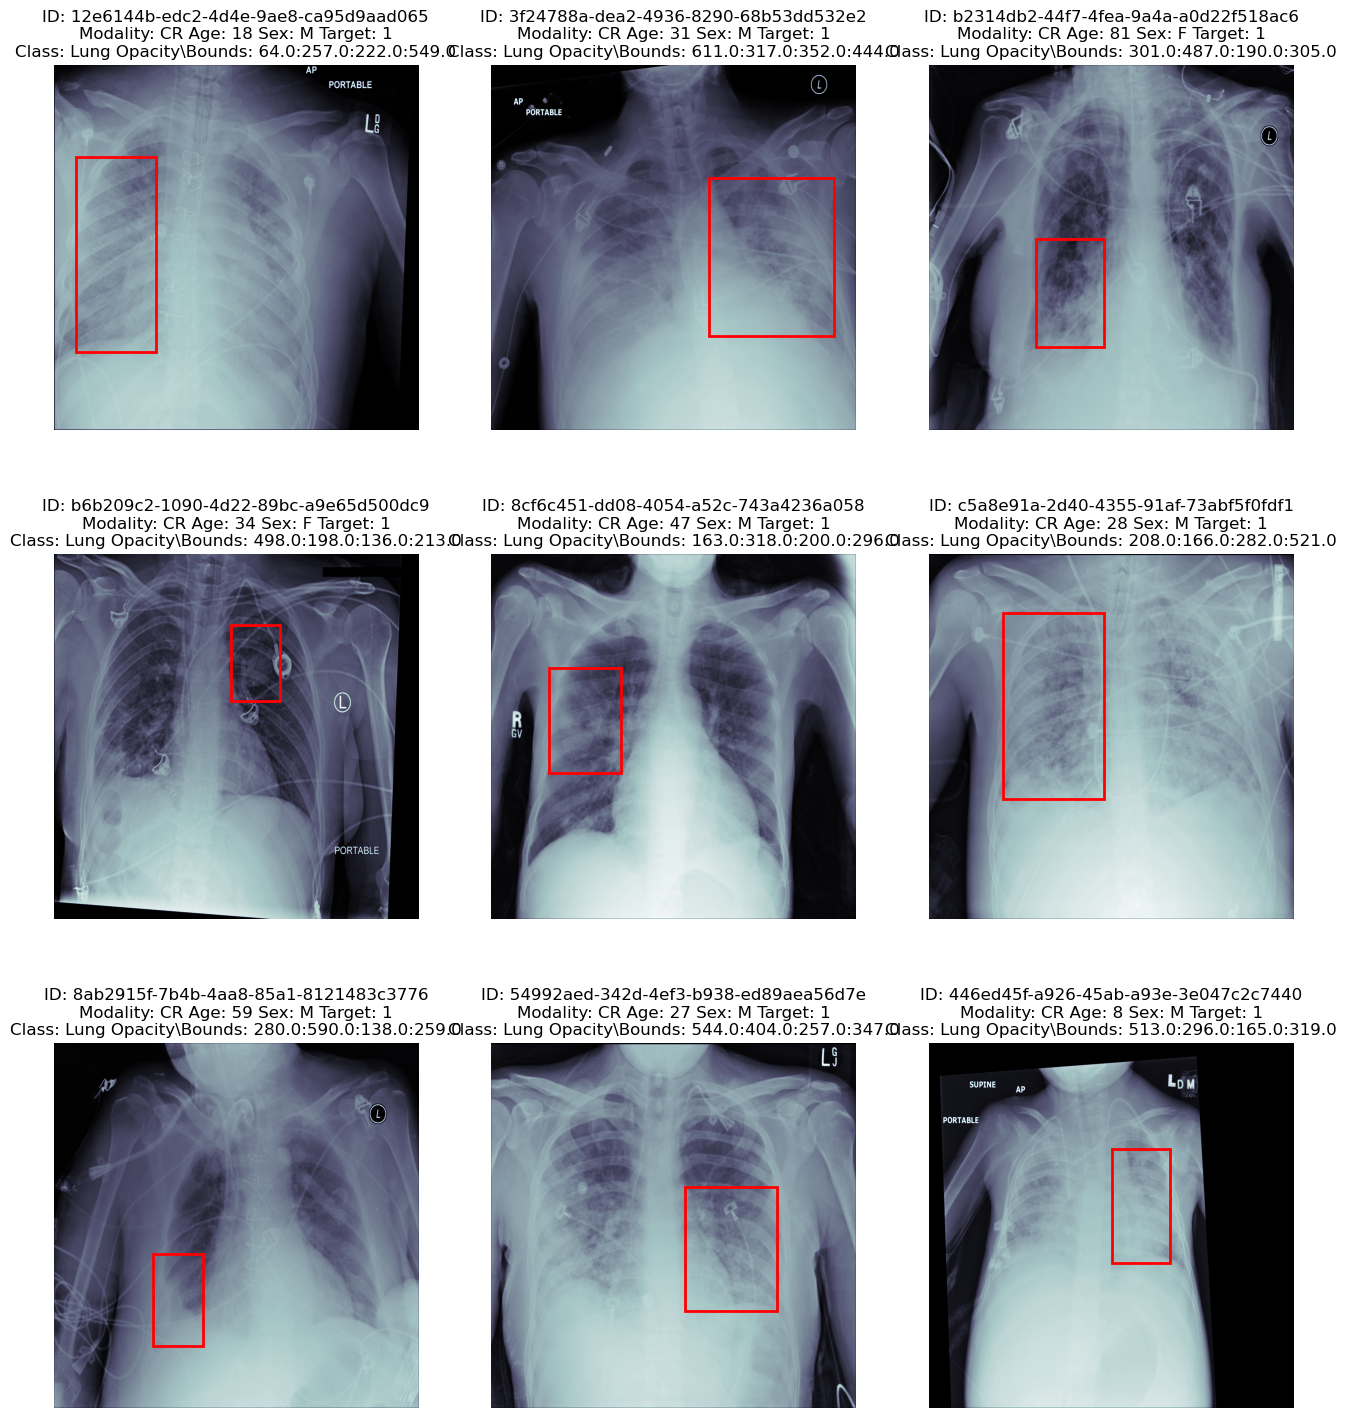

In [ ]:
## checking few images which has pneuonia 
inspectImages(training_data[training_data['Target']==1].sample(9))

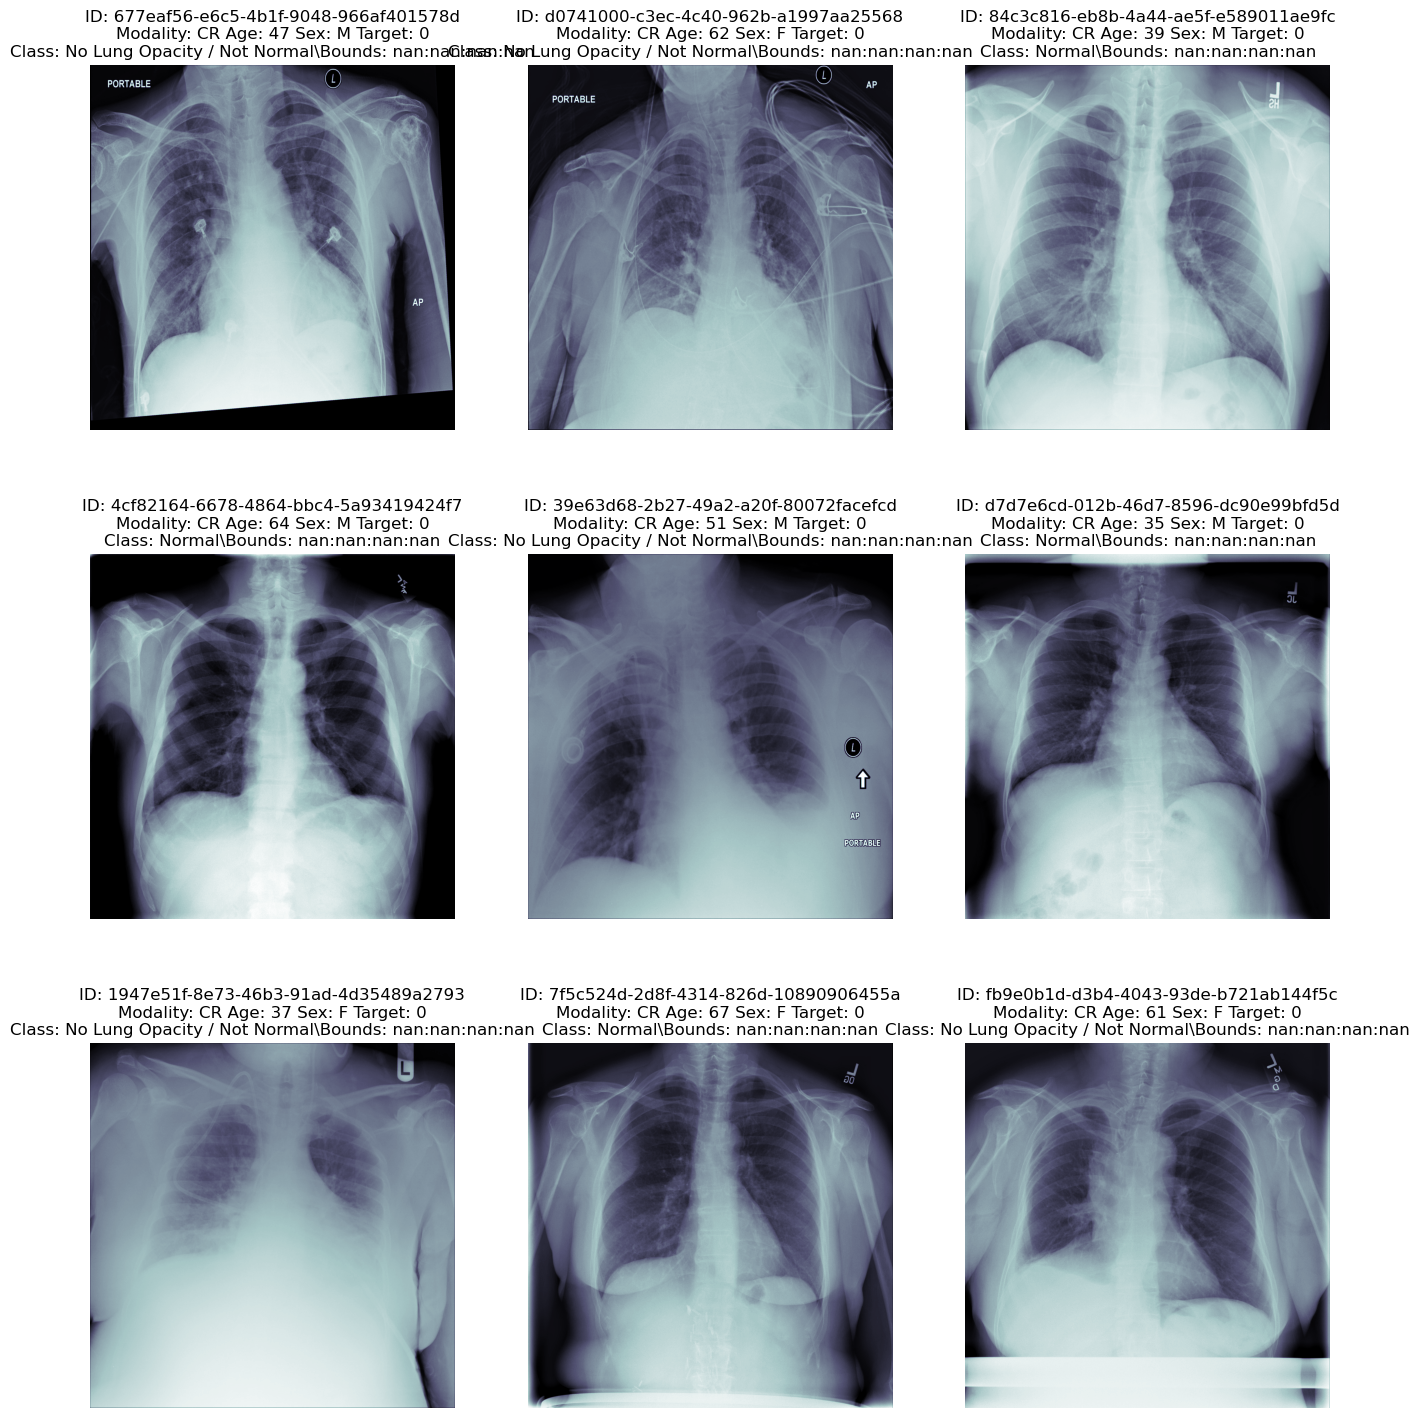

In [ ]:
## checking few images which does not have pneuonia 
inspectImages(training_data[training_data['Target']==0].sample(9))

Reading the Dicom images meta data and appending it to the training set

In [ ]:
## DCIM image contain the meta data alon with it, 
## Function to read the dcim data and appending to the resultset
def readDCIMData(rowData):
    dcm_file = 'stage_2_train_images'+'{}.dcm'.format(rowData.patientId)
    dcm_data = dcm.read_file(dcm_file)
    img = dcm_data.pixel_array
    return dcm_data.PatientSex,dcm_data.PatientAge

In [ ]:
## Reading the image data and append it to the training_data dataset
training_data['sex'], training_data['age'] = zip(*training_data.apply(readDCIMData, axis=1))

In [ ]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
 7   sex        30227 non-null  object 
 8   age        30227 non-null  object 
dtypes: float64(4), int64(1), object(4)
memory usage: 2.1+ MB


In [ ]:
# Converting age to Numeric as the current data type is a String
training_data['age'] = training_data.age.astype(int)

In [ ]:
training_data.describe(include="all").T
## The mean age is 46 years , where as minimum age is 1 year and the max age is 155 which seems to be an outlier
## 50% of the patiens are of aroudn 49 age , the std deviation is 16 which sugges that age is not normally distubuted

count unique                                   top   freq  \
patientId    30227  26684  3239951b-6211-4290-b237-3d9ad17176db      4   
x           9555.0    NaN                                   NaN    NaN   
y           9555.0    NaN                                   NaN    NaN   
width       9555.0    NaN                                   NaN    NaN   
height      9555.0    NaN                                   NaN    NaN   
Target     30227.0    NaN                                   NaN    NaN   
class        30227      3          No Lung Opacity / Not Normal  11821   
sex          30227      2                                     M  17216   
age        30227.0    NaN                                   NaN    NaN   

                 mean         std   min    25%    50%    75%    max  
patientId         NaN         NaN   NaN    NaN    NaN    NaN    NaN  
x          394.047724  204.574172   2.0  207.0  324.0  594.0  835.0  
y           366.83956  148.940488   2.0  249.0  365.0  478.5  881.0  
width      218.471376   59.289475  40.0  177.0  217.0  259.0  528.0  
height     329.269702  157.750755  45.0  203.0  298.0  438.0  942.0  
Target       0.316108    0.464963   0.0    0.0    0.0    1.0    1.0  
class             NaN         NaN   NaN    NaN    NaN    NaN    NaN  
sex               NaN         NaN   NaN    NaN    NaN    NaN    NaN  
age         46.797764    16.89294   1.0   34.0   49.0   59.0  155.0

In [ ]:
training_data.sex.value_counts()
## there are only two genders 

M    17216
F    13011
Name: sex, dtype: int64

Text(0.5, 1.0, 'Sex and Target for Chest Exams')

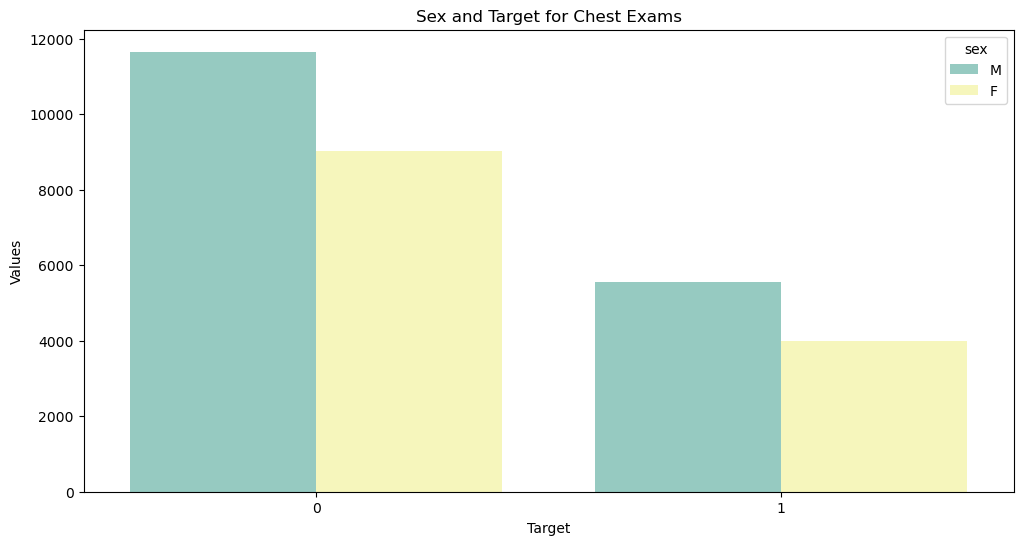

In [ ]:
## Distbution of Sex Among the tragets
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('Target')['sex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'sex', data = data_target_class, palette = 'Set3')
plt.title('Sex and Target for Chest Exams')

## the number of males in both category are higher than women

Text(0.5, 1.0, 'Sex and class for Chest Exams')

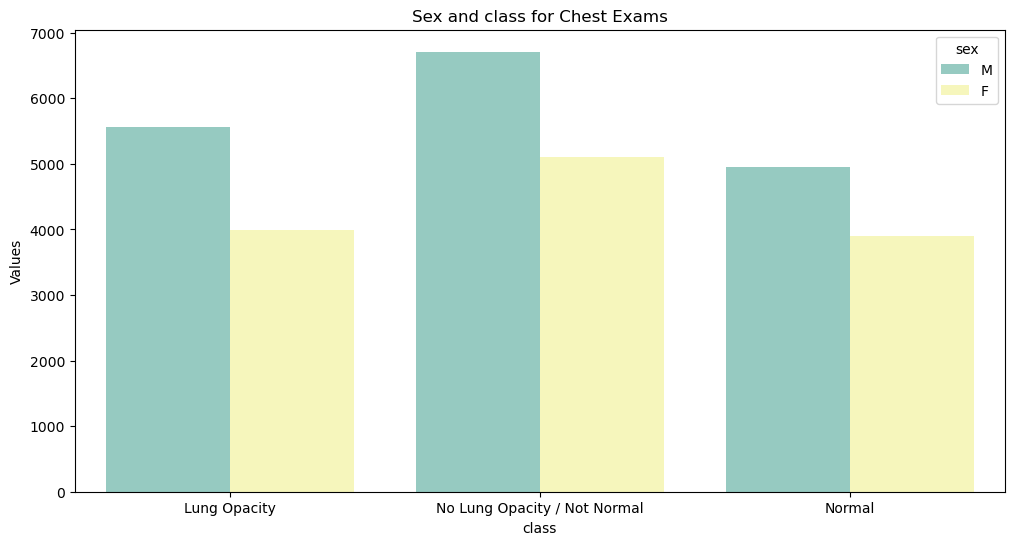

In [ ]:
## Distbution of Sex Among the classes
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('class')['sex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'class', y = 'Values', hue = 'sex', data = data_target_class, palette = 'Set3')
plt.title('Sex and class for Chest Exams')

## the number of males in all classes are higher than women

<Axes: xlabel='age', ylabel='Count'>

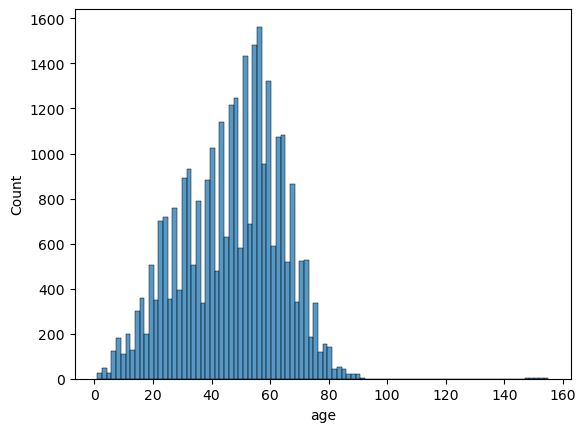

In [ ]:
sns.histplot(training_data.age)


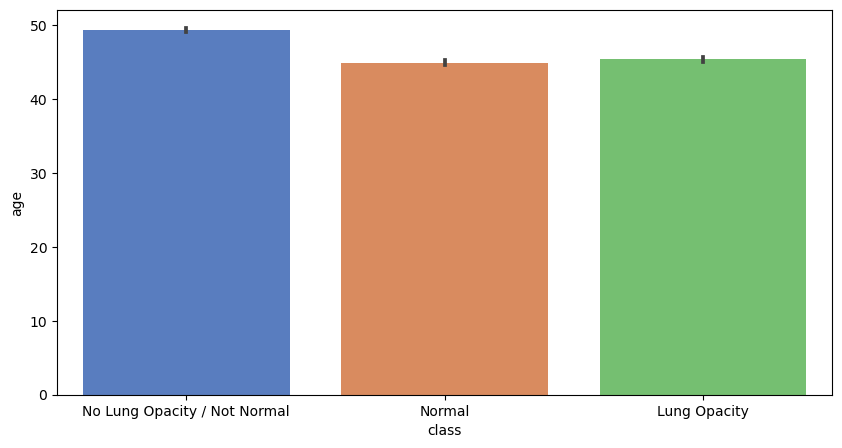

In [ ]:
plt.figure(figsize=(10,5))  # setting the figure size
ax = sns.barplot(x='class', y='age', data=training_data, palette='muted')  # barplot'
## This is the distubution of Age with class, maximum age of person with pneuomina is arund 45

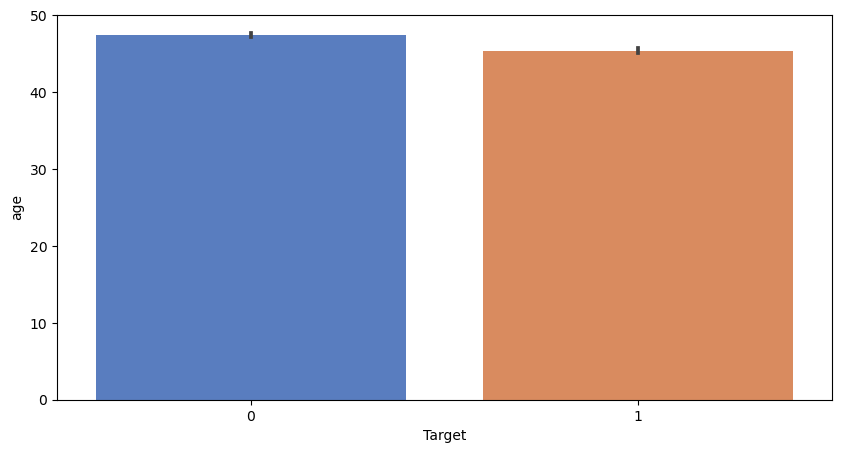

In [ ]:
plt.figure(figsize=(10,5))  # setting the figure size
ax = sns.barplot(x='Target', y='age', data=training_data, palette='muted')  # barplot'
## This is the distubution of Age with class, maximum age of person with pneuomina is arund 45


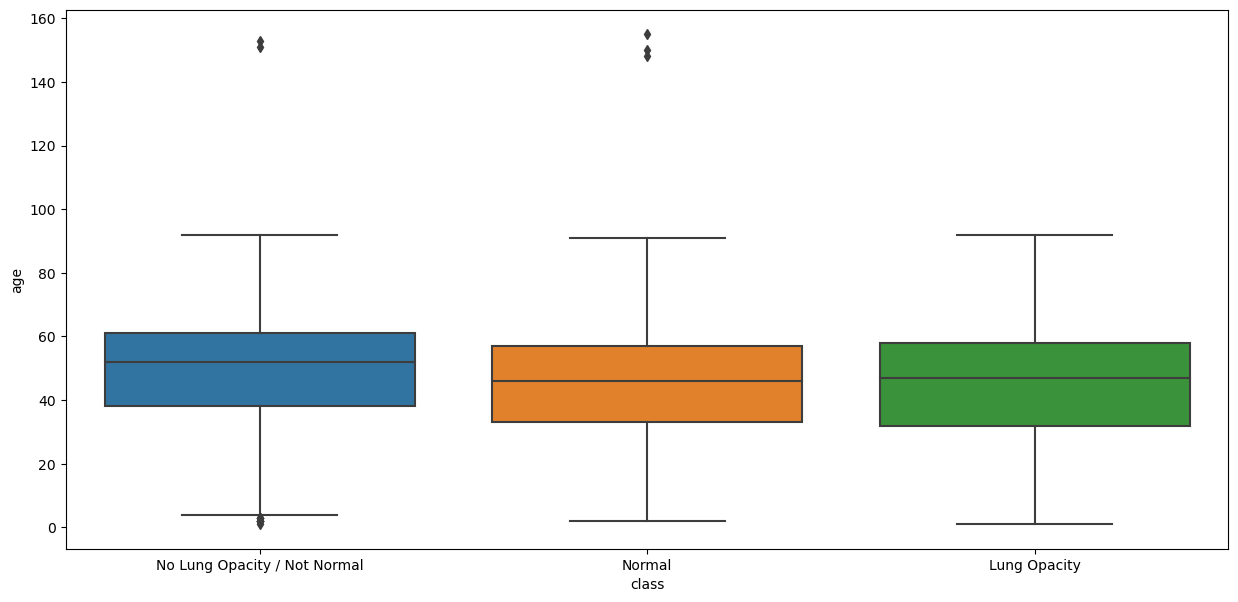

In [ ]:
plt.figure(figsize=(15,7))
sns.boxplot(x='class', y='age', data= training_data)
plt.show()

## The  class which has no pneuomia has few outliers , theie age is somewhere aroun 150 years


In [ ]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

Distribution of `Age`: Overall and Target = 1


Text(0.5, 1.0, 'Distribution of PatientAge who have pneumonia')

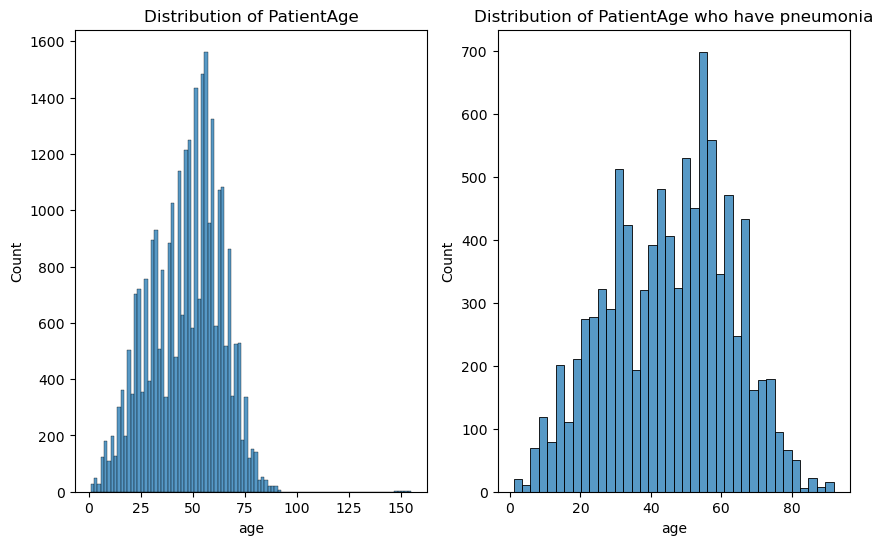

In [ ]:
print('Distribution of `Age`: Overall and Target = 1')
fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(121)
g = sns.histplot(training_data['age'])
g.set_title('Distribution of PatientAge')

ax = fig.add_subplot(122)
g = sns.histplot(training_data.loc[training_data['Target'] == 1, 'age'])
g.set_title('Distribution of PatientAge who have pneumonia')



<Axes: >

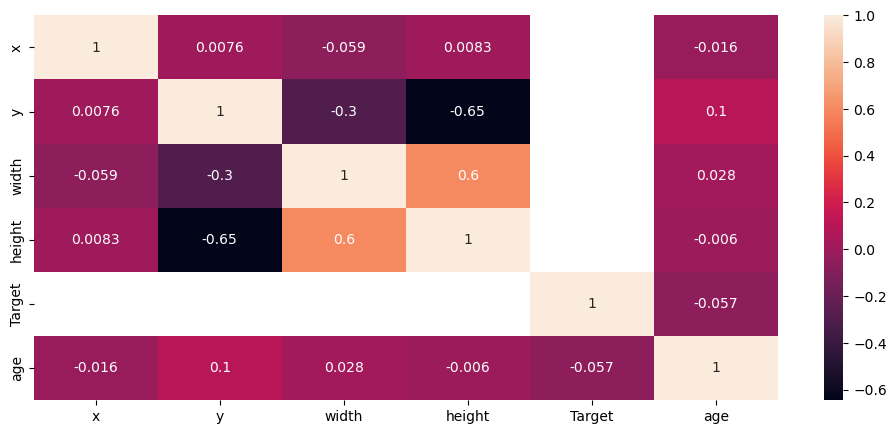

In [ ]:
corr = training_data.corr(numeric_only=True)
plt.figure(figsize=(12, 5))
sns.heatmap(corr, annot=True)

## There is high corelation between widht and height

**MODEL BUILDING**

In [ ]:
## Just taking a few samples from the dataset
sample_trainigdata = training_data.groupby('class', group_keys=False).apply(lambda x: x.sample(800))

In [ ]:
## Checking the training data set with class distbution 
sample_trainigdata["class"].value_counts()

Lung Opacity                    800
No Lung Opacity / Not Normal    800
Normal                          800
Name: class, dtype: int64

In [ ]:
sample_trainigdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2400 entries, 29327 to 21087
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  2400 non-null   object 
 1   x          800 non-null    float64
 2   y          800 non-null    float64
 3   width      800 non-null    float64
 4   height     800 non-null    float64
 5   Target     2400 non-null   int64  
 6   class      2400 non-null   object 
 7   sex        2400 non-null   object 
 8   age        2400 non-null   int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 187.5+ KB


In [ ]:
## Pre Processing the image
from tensorflow.keras.applications.mobilenet import preprocess_input

images = []
ADJUSTED_IMAGE_SIZE = 128
imageList = []
classLabels = []
labels = []
originalImage = []
# Function to read the image from the path and reshape the image to size
def readAndReshapeImage(image):
    img = np.array(image).astype(np.uint8)
    ## Resize the image
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

## Read the imahge and resize the image
def populateImage(rowData):
    for index, row in rowData.iterrows():
        patientId = row.patientId
        classlabel = row["class"]
        dcm_file = 'stage_2_train_images'+'{}.dcm'.format(patientId)
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array
        ## Converting the image to 3 channels as the dicom image pixel does not have colour classes wiht it
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
        imageList.append(readAndReshapeImage(img))
#         originalImage.append(img)
        classLabels.append(classlabel)
    tmpImages = np.array(imageList)
    tmpLabels = np.array(classLabels)
#     originalImages = np.array(originalImage)
    return tmpImages,tmpLabels

In [ ]:
## Reading the images into numpy array
images,labels = populateImage(sample_trainigdata)

In [ ]:
images.shape , labels.shape
## The image is of 128*128 with 3 channels

((2400, 128, 128, 3), (2400,))

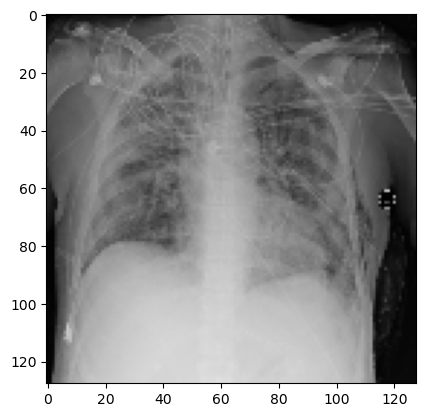

In [ ]:
## Checking one of the converted image 
plt.imshow(images[100])

In [ ]:
## check the unique labels
np.unique(labels),len(np.unique(labels))

(array(['Lung Opacity', 'No Lung Opacity / Not Normal', 'Normal'],
       dtype='<U28'),
 3)

In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
# define model
from tensorflow.keras import losses,optimizers
from tensorflow.keras.layers import Dense,  Activation, Flatten,Dropout,MaxPooling2D,BatchNormalization
import pandas as pd
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats 
import matplotlib.pyplot as plt
from tensorflow import keras
#from keras.models import Sequential
#from keras.layers import Dense
#from sklearn.model_selection import StratifiedKFold
%matplotlib inline
#Test Train Split
from sklearn.model_selection import train_test_split
#Feature Scaling library
from sklearn.preprocessing import StandardScaler
#import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense ,LeakyReLU
from tensorflow.keras import regularizers, optimizers
from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential  # initial NN
from keras.layers import Dense, Dropout # construct each layer
from keras.layers import Conv2D # swipe across the image by 1
from keras.layers import MaxPooling2D # swipe across by pool size
from keras.layers import Flatten, GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [ ]:
## encoding the labels
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y2 = enc.fit_transform(labels)

In [ ]:
## splitting into train ,test and validation data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y2, test_size=0.3, random_state=50)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=50)

In [ ]:
## FUnction to create a dataframe for results
def createResultDf(name,accuracy,testscore):
    result = pd.DataFrame({'Method':[name], 'accuracy': [accuracy] ,'Test Score':[testscore]})
    return result

In [ ]:
def cnn_model(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  batch_size = None

  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))


  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.4))



  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = "softmax"))

  model.summary()
  return model

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Define your model
ADJUSTED_IMAGE_SIZE = 128  # or whatever your actual image size is
num_channels = 3  # for RGB images
num_classes = 3  # replace with the actual number of classes in your dataset

cnn = cnn_model(ADJUSTED_IMAGE_SIZE, ADJUSTED_IMAGE_SIZE, num_channels, num_classes)

# Define learning rate schedule
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)

# Compile your model
optimizer = RMSprop(learning_rate=lr_schedule)
cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       36992     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                        

In [ ]:
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.graph_options.optimizer_options.global_jit_level = tf.compat.v1.OptimizerOptions.OFF
session = InteractiveSession(config=config)

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf


# Fit your model
history = cnn.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=30)

Epoch 1/30


2023-06-01 06:59:45.311322: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


56/56 [==============================] - 16s 74ms/step - loss: 3.0677 - accuracy: 0.3440 - val_loss: 1.0996 - val_accuracy: 0.3250
Epoch 2/30
56/56 [==============================] - 4s 69ms/step - loss: 1.1164 - accuracy: 0.3387 - val_loss: 1.0952 - val_accuracy: 0.3444
Epoch 3/30
56/56 [==============================] - 4s 69ms/step - loss: 1.1101 - accuracy: 0.3226 - val_loss: 1.0796 - val_accuracy: 0.3667
Epoch 4/30
56/56 [==============================] - 4s 69ms/step - loss: 1.1109 - accuracy: 0.3708 - val_loss: 1.0790 - val_accuracy: 0.4139
Epoch 5/30
56/56 [==============================] - 4s 70ms/step - loss: 1.0793 - accuracy: 0.4167 - val_loss: 1.0781 - val_accuracy: 0.4028
Epoch 6/30
56/56 [==============================] - 4s 72ms/step - loss: 1.0975 - accuracy: 0.4036 - val_loss: 1.0700 - val_accuracy: 0.4611
Epoch 7/30
56/56 [==============================] - 4s 69ms/step - loss: 1.0565 - accuracy: 0.4417 - val_loss: 1.0314 - val_accuracy: 0.4861
Epoch 8/30
56/56 [=====

In [ ]:

fcl_loss, fcl_accuracy = cnn.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

12/12 [==============================] - 2s 45ms/step - loss: 1.0864 - accuracy: 0.4556
Test loss: 1.0863769054412842
Test accuracy: 0.4555555582046509


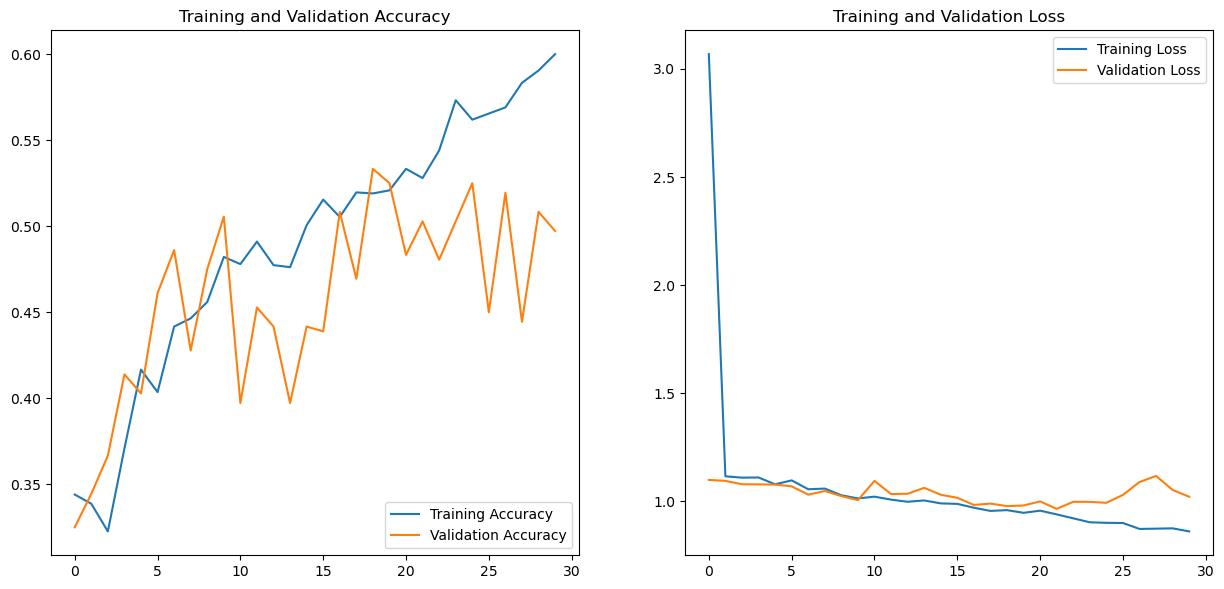

In [ ]:
# Extract the history of accuracy and loss values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
resultDF = createResultDf("CNN",acc[-1],fcl_accuracy)

12/12 [==============================] - 0s 14ms/step


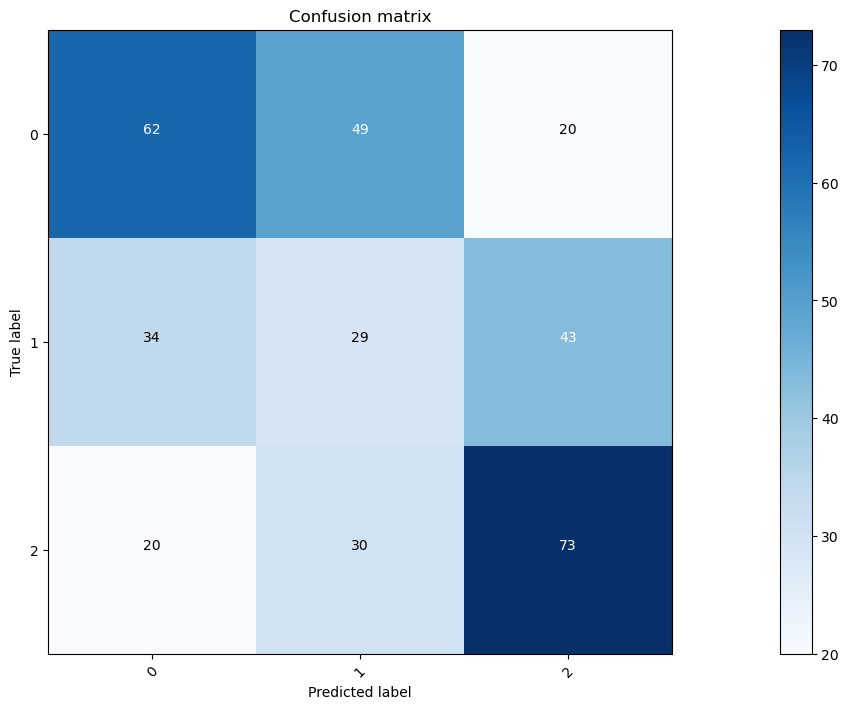

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = cnn.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

#Class 0 ,1 and 2
#Class 0 is Lung Opacity
#Class 1 is No Lung Opacity/Normal, the model has predicted mostly wrong in this case to the Target 0. Type 2 error
#Class 2 is Normal


In [ ]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnn.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultDF[data+"_"+subData] = reportData[data][subData]

resultDF

12/12 [==============================] - 0s 14ms/step


Method  accuracy  Test Score  1_precision  1_recall  1_f1-score  1_support
0    CNN       0.6    0.455556     0.268519  0.273585    0.271028        106

In [ ]:
## Creating a Copy
X_train1 = X_train.copy()
X_val1 = X_val.copy()
X_test1 = X_test.copy()

**CNN with Tranfer learning using VGG16**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

##VGGNet is a well-documented and globally used architecture for convolutional neural network
## Include_top=False to remove the classification layer that was trained on the ImageNet dataset and set the model as not trainable

base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(X_train1) 
train_val_df = preprocess_input(X_val1)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(100, activation='relu')
dropout_layer_1 = layers.Dropout(0.3)
dense_layer_2 = layers.Dense(50, activation='relu')
dropout_layer_2 = layers.Dropout(0.3)
dense_layer_3 = layers.Dense(20, activation='relu')
dropout_layer_3 = layers.Dropout(0.3)
prediction_layer = layers.Dense(3, activation='softmax')

cnn_VGG16_model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer_1,
    dense_layer_2,
    dropout_layer_2,
    dense_layer_3,
    dropout_layer_3,
    prediction_layer
])


In [ ]:
cnn_VGG16_model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

#Trainign the model
history = cnn_VGG16_model.fit(train_ds, y_train, epochs=30, validation_data=(train_val_df,y_val))


Epoch 1/30
53/53 [==============================] - 9s 95ms/step - loss: 1.8849 - accuracy: 0.3726 - val_loss: 0.6698 - val_accuracy: 0.3778
Epoch 2/30
53/53 [==============================] - 3s 54ms/step - loss: 0.6959 - accuracy: 0.3702 - val_loss: 0.6583 - val_accuracy: 0.4056
Epoch 3/30
53/53 [==============================] - 3s 54ms/step - loss: 0.6638 - accuracy: 0.4149 - val_loss: 0.5862 - val_accuracy: 0.5361
Epoch 4/30
53/53 [==============================] - 3s 51ms/step - loss: 0.6362 - accuracy: 0.4792 - val_loss: 0.5680 - val_accuracy: 0.5056
Epoch 5/30
53/53 [==============================] - 3s 53ms/step - loss: 0.6008 - accuracy: 0.4744 - val_loss: 0.5379 - val_accuracy: 0.5806
Epoch 6/30
53/53 [==============================] - 3s 51ms/step - loss: 0.6018 - accuracy: 0.4786 - val_loss: 0.5891 - val_accuracy: 0.5167
Epoch 7/30
53/53 [==============================] - 3s 54ms/step - loss: 0.5920 - accuracy: 0.5048 - val_loss: 0.5631 - val_accuracy: 0.5417
Epoch 8/30
53

In [ ]:
test_ds = preprocess_input(X_test1) 
fcl_loss, fcl_accuracy = cnn_VGG16_model.evaluate(test_ds, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)


12/12 [==============================] - 1s 42ms/step - loss: 0.5704 - accuracy: 0.5750
Test loss: 0.5703691840171814
Test accuracy: 0.574999988079071


In [ ]:
actual_train_accuracy = history.history['accuracy'][-1]
actual_val_accuracy = history.history['val_accuracy'][-1]

print('Actual Training Accuracy:', actual_train_accuracy)
print('Actual Validation Accuracy:', actual_val_accuracy)


Actual Training Accuracy: 0.7130952477455139
Actual Validation Accuracy: 0.6472222208976746


In [ ]:
resultsDf1 = pd.concat([resultDF, createResultDf("CNN With VGG16",history.history['accuracy'][-1],fcl_accuracy)])

In [ ]:
resultsDf1.head()

Method  accuracy  Test Score  1_precision  1_recall  1_f1-score  \
0             CNN  0.600000    0.455556     0.268519  0.273585    0.271028   
0  CNN With VGG16  0.713095    0.575000          NaN       NaN         NaN   

   1_support  
0      106.0  
0        NaN

In [ ]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnn.predict(test_ds)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultsDf1[data+"_"+subData] = reportData[data][subData]

resultsDf1

12/12 [==============================] - 0s 17ms/step


Method  accuracy  Test Score  1_precision  1_recall  1_f1-score  \
0             CNN  0.600000    0.455556     0.268519  0.273585    0.271028   
0  CNN With VGG16  0.713095    0.575000     0.268519  0.273585    0.271028   

   1_support  
0        106  
0        106

**CNN with ResNet50**

In [ ]:
from tensorflow.keras.applications import ResNet50

from tensorflow.keras import layers

# Existing layers
resnet_base_model = ResNet50(include_top=False, weights='imagenet', input_shape=X_train[0].shape)
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(256, activation='relu')  # increased the number of neurons
dense_layer_2 = layers.Dense(128, activation='relu')  # increased the number of neurons
prediction_layer = layers.Dense(3, activation='softmax')

# Additional layers
additional_dense_layer = layers.Dense(64, activation='relu')  # reduced the number of neurons
dropout_layer_1 = layers.Dropout(0.5)  # You can adjust the dropout rate as needed
dropout_layer_2 = layers.Dropout(0.3)  # You can adjust the dropout rate as needed

cnn_resnet_model = models.Sequential([
    resnet_base_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer_1,  # Add the dropout layer after the first dense layer
    additional_dense_layer,  # Add the additional dense layer
    dropout_layer_2,  # Add another dropout layer after the additional dense layer
    dense_layer_2,
    prediction_layer
])

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

cnn_resnet_model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


In [ ]:
#Trainign the model
history =cnn_resnet_model.fit(train_ds, y_train, epochs=30, validation_data=(train_val_df,y_val))

Epoch 1/30
53/53 [==============================] - 51s 205ms/step - loss: 0.7924 - accuracy: 0.4536 - val_loss: 11.2790 - val_accuracy: 0.3222
Epoch 2/30
53/53 [==============================] - 7s 127ms/step - loss: 0.5943 - accuracy: 0.5464 - val_loss: 2.6315 - val_accuracy: 0.4056
Epoch 3/30
53/53 [==============================] - 7s 128ms/step - loss: 0.5230 - accuracy: 0.5911 - val_loss: 30.9785 - val_accuracy: 0.3361
Epoch 4/30
53/53 [==============================] - 7s 132ms/step - loss: 0.5178 - accuracy: 0.5994 - val_loss: 12.6205 - val_accuracy: 0.3722
Epoch 5/30
53/53 [==============================] - 7s 126ms/step - loss: 0.4978 - accuracy: 0.6262 - val_loss: 3.4493 - val_accuracy: 0.3861
Epoch 6/30
53/53 [==============================] - 7s 125ms/step - loss: 0.4559 - accuracy: 0.6756 - val_loss: 1.8036 - val_accuracy: 0.6028
Epoch 7/30
53/53 [==============================] - 7s 130ms/step - loss: 0.4158 - accuracy: 0.7036 - val_loss: 0.4960 - val_accuracy: 0.6056
Ep

In [ ]:
fcl_loss, fcl_accuracy = cnn_resnet_model.evaluate(test_ds, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

12/12 [==============================] - 1s 39ms/step - loss: 1.2741 - accuracy: 0.6222
Test loss: 1.2740602493286133
Test accuracy: 0.6222222447395325


In [ ]:
resultsDf2 = pd.concat([resultsDf1, createResultDf("CNN With ResNet50",history.history['accuracy'][-1],fcl_accuracy)])

In [ ]:
resultsDf2.head()

Method  accuracy  Test Score  1_precision  1_recall  1_f1-score  \
0                CNN  0.600000    0.455556     0.268519  0.273585    0.271028   
0     CNN With VGG16  0.713095    0.575000     0.268519  0.273585    0.271028   
0  CNN With ResNet50  0.956548    0.622222          NaN       NaN         NaN   

   1_support  
0      106.0  
0      106.0  
0        NaN

In [ ]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnn.predict(test_ds)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultsDf2[data+"_"+subData] = reportData[data][subData]

12/12 [==============================] - 0s 15ms/step


12/12 [==============================] - 1s 31ms/step


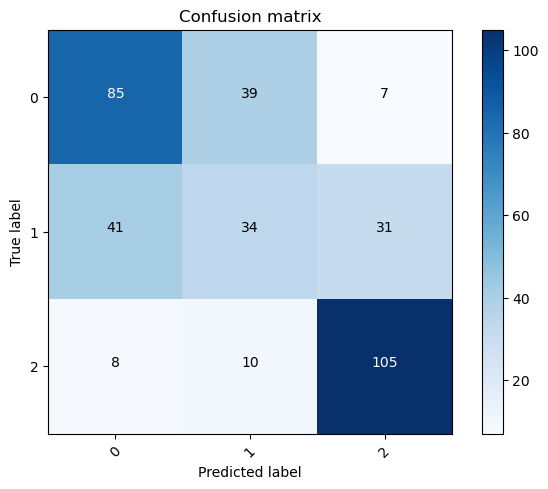

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = cnn_resnet_model.predict(test_ds)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1) 
# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(3))


In [ ]:
resultsDf2.head()

Method  accuracy  Test Score  1_precision  1_recall  1_f1-score  \
0                CNN  0.600000    0.455556     0.268519  0.273585    0.271028   
0     CNN With VGG16  0.713095    0.575000     0.268519  0.273585    0.271028   
0  CNN With ResNet50  0.956548    0.622222     0.268519  0.273585    0.271028   

   1_support  
0        106  
0        106  
0        106

**CNN with Xception**

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras import layers, models

xception_base_model = Xception(include_top=False, weights='imagenet', input_shape=X_train[0].shape)

train_ds = preprocess_input(X_train1) 
train_val_df = preprocess_input(X_val1)

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(1024, activation='relu')
dropout_layer_1 = layers.Dropout(0.3)
dense_layer_2 = layers.Dense(512, activation='relu')
dropout_layer_2 = layers.Dropout(0.3)
dense_layer_3 = layers.Dense(256, activation='relu')
dropout_layer_3 = layers.Dropout(0.3)
dense_layer_4 = layers.Dense(128, activation='relu')
dropout_layer_4 = layers.Dropout(0.3)
dense_layer_5 = layers.Dense(64, activation='relu')
dropout_layer_5 = layers.Dropout(0.3)
dense_layer_6 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(3, activation='softmax')

cnn_xception_model = models.Sequential([
    xception_base_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer_1,
    dense_layer_2,
    dropout_layer_2,
    dense_layer_3,
    dropout_layer_3,
    dense_layer_4,
    dropout_layer_4,
    dense_layer_5,
    dropout_layer_5,
    dense_layer_6,
    prediction_layer
])


83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
# Compile the model
cnn_xception_model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
# Train the model
history = cnn_xception_model.fit(train_ds, y_train, epochs=30, validation_data=(train_val_df,y_val))

Epoch 1/30
53/53 [==============================] - 45s 234ms/step - loss: 0.6686 - accuracy: 0.3548 - val_loss: 0.7188 - val_accuracy: 0.3639
Epoch 2/30
53/53 [==============================] - 10s 180ms/step - loss: 0.6421 - accuracy: 0.3595 - val_loss: 0.5790 - val_accuracy: 0.5278
Epoch 3/30
53/53 [==============================] - 9s 178ms/step - loss: 0.5844 - accuracy: 0.4988 - val_loss: 7.0089 - val_accuracy: 0.5111
Epoch 4/30
53/53 [==============================] - 9s 175ms/step - loss: 0.5339 - accuracy: 0.5780 - val_loss: 2.3926 - val_accuracy: 0.5417
Epoch 5/30
53/53 [==============================] - 9s 176ms/step - loss: 0.4795 - accuracy: 0.6131 - val_loss: 9.6171 - val_accuracy: 0.4472
Epoch 6/30
53/53 [==============================] - 9s 176ms/step - loss: 0.4756 - accuracy: 0.6131 - val_loss: 2.5813 - val_accuracy: 0.5861
Epoch 7/30
53/53 [==============================] - 9s 175ms/step - loss: 0.4384 - accuracy: 0.6708 - val_loss: 3.7596 - val_accuracy: 0.6194
Epoc

In [ ]:
fcl_loss, fcl_accuracy = cnn_xception_model.evaluate(test_ds, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)



12/12 [==============================] - 1s 47ms/step - loss: 856.5635 - accuracy: 0.3417
Test loss: 856.5635375976562
Test accuracy: 0.34166666865348816


In [ ]:
resultsDf3 = pd.concat([resultsDf2, createResultDf("CNN With Xception",history.history['accuracy'][-1],fcl_accuracy)])

In [ ]:
resultsDf3.head()

Method  accuracy  Test Score  1_precision  1_recall  1_f1-score  \
0                CNN  0.600000    0.455556     0.268519  0.273585    0.271028   
0     CNN With VGG16  0.713095    0.575000     0.268519  0.273585    0.271028   
0  CNN With ResNet50  0.956548    0.622222     0.268519  0.273585    0.271028   
0  CNN With Xception  0.978571    0.341667          NaN       NaN         NaN   

   1_support  
0      106.0  
0      106.0  
0      106.0  
0        NaN

In [ ]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnn.predict(test_ds)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultsDf3[data+"_"+subData] = reportData[data][subData]
resultsDf3

12/12 [==============================] - 0s 15ms/step


Method  accuracy  Test Score  1_precision  1_recall  1_f1-score  \
0                CNN  0.600000    0.455556     0.409639  0.320755    0.359788   
0     CNN With VGG16  0.713095    0.575000     0.409639  0.320755    0.359788   
0  CNN With ResNet50  0.956548    0.622222     0.409639  0.320755    0.359788   
0  CNN With Xception  0.978571    0.341667     0.409639  0.320755    0.359788   

   1_support  
0        106  
0        106  
0        106  
0        106

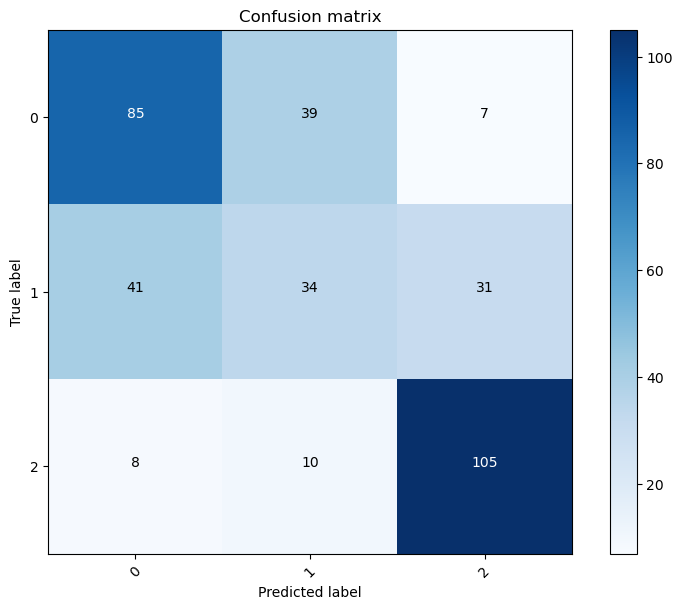

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Define the function to plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
class_names = [0, 1, 2]  # Replace with your actual class names
plot_confusion_matrix(confusion_mtx, classes=class_names, normalize=False)

# Display the plot
plt.show()


In [ ]:
resultsDf3.head()

Method  accuracy  Test Score  1_precision  1_recall  1_f1-score  \
0                CNN  0.600000    0.455556     0.409639  0.320755    0.359788   
0     CNN With VGG16  0.713095    0.575000     0.409639  0.320755    0.359788   
0  CNN With ResNet50  0.956548    0.622222     0.409639  0.320755    0.359788   
0  CNN With Xception  0.978571    0.341667     0.409639  0.320755    0.359788   

   1_support  
0        106  
0        106  
0        106  
0        106

**Here we can see the CNN With Xception giving good accuracy rather then other model**

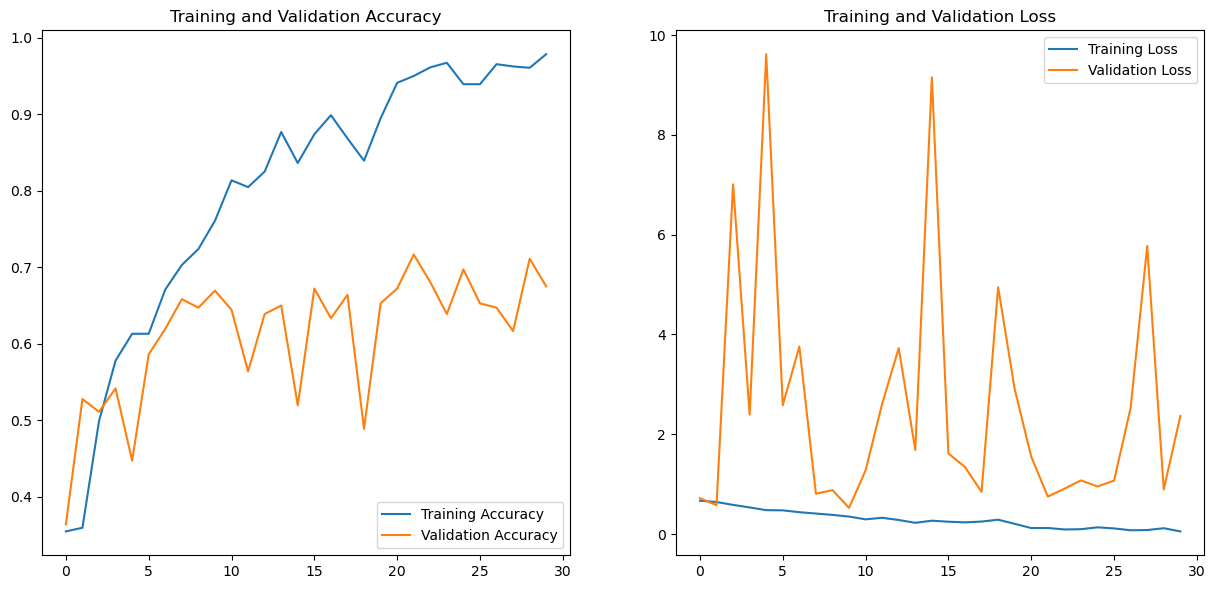

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(30)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Inferences

* Our project started with exploring the given dataset and find how the various attributes (obtained from both the files and images) are spread across the entire dataset
* The training dataset (both of the csv files and the training image folder) contains information of 26684 patients (unique)
* Out of these 26684 unique patients some of these have multiple entries in the both of the csv files
* Most of the recorded patient belong to Target = 0 (i.e., they don't have Pneumonia)
* Some of the patients have more than one bounding box. The maximum being 4
* The classes "No Lung Opacity / Not Normal" and "Normal" is associated with Target = 0 whereas "Lung Opacity" belong to Target = 1
* The images are present in dicom format, from which information like PatientAge, PatientSex, ViewPosition etc are obtained
* There are two ways from which images were obtained: AP and PA. The age ranges from 1-155 (which were further clipped to 100)
* The centers of the bounding box are spread out over the entire region of the lungs. But there are some centers which are outliers.
* Mainly, there were two challenges for us: First to write a function that can load the entire dataset at once and secondly Model Selection. Model selection was a challenge as both localization and classification were needed to clubbed into one. We tried to develop a model on just ResNet, VGG16 and Xception.
* After training all the three variants we sticked with Xception with overall accuracy was 97%.